# Mass--concentration relations from GMMs

To demonstrate the power of our approach, let's show how we can recreate mass--concentration relations from our GMMs. We will take from our catalogs measurements of the ($200m$ and NFW) concentration $c$ and peak height $\nu$ of a bunch of halos. We will model the distribution with a Gaussian mixture model (GMM), and demonstrate how conditional statistics can recover usual M-c relations (in this case $\nu$-c relations).

In [1]:
import ConditionalGMM
import itertools
import numpy as np
from scipy import linalg
from sklearn import mixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

%matplotlib inline

In [2]:
#Plotting format
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=20)

In [3]:
#Read in the pickled pandas dataframe
df = pd.read_pickle("./sparta_cats/L2000_N1024_CBol/df_L2000_sf1_CBol.pkl")

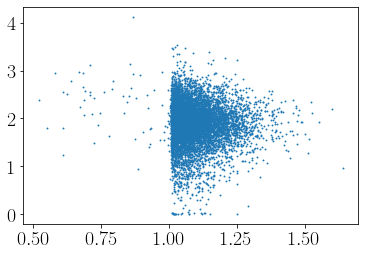

In [4]:
c = df.c200b
nu = df.nu200b
plt.scatter(np.log(nu), np.log(c), 0.8)
#plt.xlim(1, 1.01)

In [5]:
#Let's cut the crazy outlier with c~60 and with too-small concentrations (they don't make sense)
#Also cut out the very small peak heights
cut = np.where((c < 40) & (np.log(c) > 0.2) & (np.log(nu) > 1.0075) == True)[0]
nu = nu[cut]
c = c[cut]
X = np.array([np.log(nu), np.log(c)]).T
print(c.shape, nu.shape, X.shape)

(7844,) (7844,) (7844, 2)


[1377.16565974 1834.13352756 2031.98201215 2072.15325176 2112.11702561
 2123.47348327 2108.75225236 2115.78194265 2102.1262725  2176.29082283]


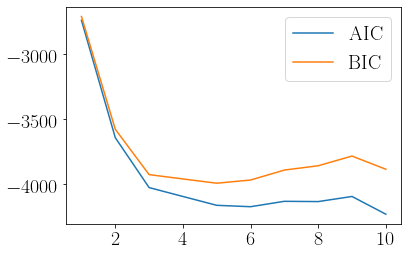

In [6]:
#Train a GMM - figure out how many components we need
X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)
n_components = np.arange(1, 10+1)
scores = np.zeros_like(n_components, dtype="float")
BIC = np.zeros_like(scores)
AIC = np.zeros_like(scores)
for i, n in enumerate(n_components):
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(X_train)
    scores[i] = gmm.score_samples(X_test).sum()
    BIC[i] = gmm.bic(X_test)
    AIC[i] = gmm.aic(X_test)
print(scores)
plt.plot(n_components, AIC, label="AIC")
plt.plot(n_components, BIC, label="BIC")
plt.legend()

In [7]:
#5 Components seems reasonable, since it satisfies the BIC
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
weights = gmm.weights_
means = gmm.means_
covs = gmm.covariances_
cGMM = ConditionalGMM.CondGMM(weights, means, covs, fixed_indices=[0])
print(weights)

[0.12121811 0.29656068 0.24446145 0.05904696 0.27871281]


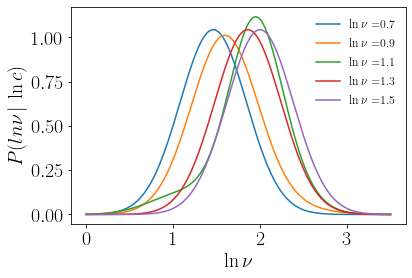

In [8]:
#colors = ["blue", "orange", "green"]

lnnu_obs = np.linspace(0.7, 1.5, 5)
lnc = np.linspace(0, 3.5, 200)
for i, lnnu in enumerate(lnnu_obs):
    lnc_cpdf = np.array([cGMM.conditional_pdf([yi], lnnu) for yi in lnc])
    plt.plot(lnc, lnc_cpdf, label=r"$\ln \nu=${x:.1f}".format(x=lnnu))#, color=colors[i])
plt.xlabel(r"$\ln \nu$")
plt.ylabel(r"$P(ln \nu\,|\,\ln c)$")
plt.legend(frameon=False, fontsize=12)

Text(0, 0.5, '${\\rm E}[\\ln c|\\ln \\nu]$')

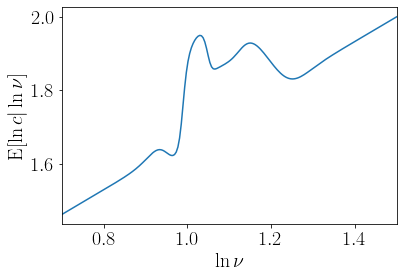

In [9]:
lnnu_obs = np.linspace(0.7, 1.5, 200)
lnc_mean = np.zeros_like(lnnu_obs)
for i, x in enumerate(lnnu_obs):
    lnc_mean[i] = cGMM.conditional_mean([x])
plt.plot(lnnu_obs, lnc_mean)
plt.xlim(min(lnnu_obs), max(lnnu_obs))
plt.xlabel(r"$\ln \nu$")
plt.ylabel(r"${\rm E}[\ln c|\ln \nu]$")

In [10]:
#There's probably not enough S/N to do this fit well. I'll have to wait until I get a hold of all the boxes.